In [1]:
# Title: 3D Image Classification
# Author: Hasib Zunair
# Date created: 2020/09/5
# Last modified: 2020/09/17
# Description: Training a 3D convolutional neural network to classify location of cancer from CT scans.

import os
import zipfile
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers

Cancer detection using CT scans, the goal is to identify locations (left or right) of possible cancerous regions by assigning a probability for each location.

In [2]:
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.1/NSCLC-Radiomics-Genomics.zip"
filename = os.path.join(os.getcwd(), "NSCLC-Radiomics-Genomics.zip")
keras.utils.get_file(filename, url)

with zipfile.ZipFile("NSCLC-Radiomics-Genomics.zip", "r") as z_fp:
    z_fp.extractall("./")

1927217152/1927209723 [==============================] - 116s 0us/step


In [3]:
import numpy as np
import nibabel as nib
import cv2

from scipy.ndimage import zoom

# The files are provided in Nifti format (*.nii). To read in the scans, we will use the nibabel package
# Volumes are originally rotated, so we use np.rot90 to fix the orientation.

def read_nifti_file(filepath):
    """
    Reads a *.nii file and return the volume as a numpy array.

    Args:
      path : path of the *.nii file

    Returns
      Numpy array of the 3D volume
    """

    scan = nib.load(filepath)
    scan   = scan.get_fdata()
    scan   = np.rot90(np.array(scan))
    return scan

def resize_slices(img):
    flatten = [cv2.resize(img[:,:,i], (128, 128), interpolation=cv2.INTER_CUBIC) for i in range(img.shape[-1])]
    img = np.array(np.dstack(flatten)) 
    return img

def resize_depth(img):
    desired_depth = 128
    current_depth = img.shape[-1]
    depth = current_depth / desired_depth
    depth_factor = 1 / depth
    img_new = zoom(img, (1, 1, depth_factor), mode='nearest')
    return img_new

def process_scan(path):
  # Read scan
  volume = read_nifti_file(path)
  # Resize width and height
  volume = resize_slices(volume)
  # Resize depthwise
  volume = resize_depth(volume)
  return volume

In [4]:
right_scan_paths = [os.path.join(os.getcwd(), "NSCLC-Radiomics-Genomics/1", x) for x in os.listdir("NSCLC-Radiomics-Genomics/1")]
left_scan_paths = [os.path.join(os.getcwd(), "NSCLC-Radiomics-Genomics/2", x) for x in os.listdir("NSCLC-Radiomics-Genomics/2")]
print(len(right_scan_paths), len(left_scan_paths))

20 20


Dimension of the CT scan is: (512, 512, 253)


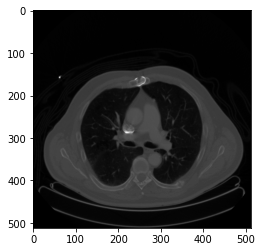

In [5]:
import matplotlib.pyplot as plt

img = read_nifti_file(right_scan_paths[2])
print("Dimension of the CT scan is:", img.shape)
plt.imshow(img[:,:,150], cmap="gray")

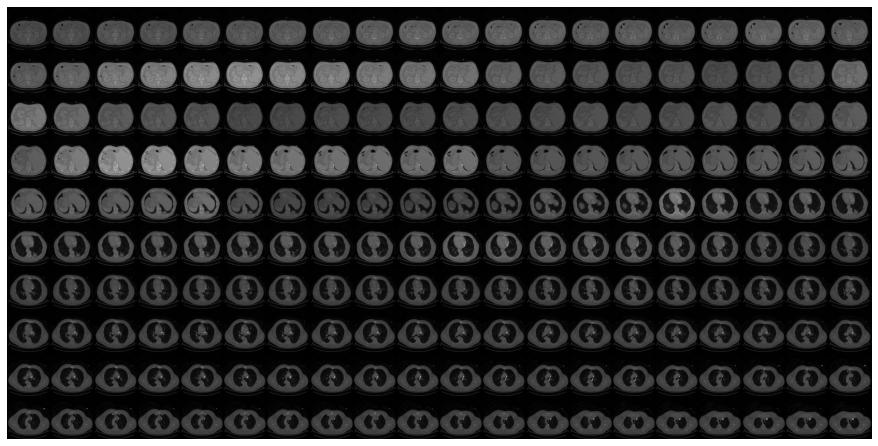

In [6]:
def plot_slices(data):
    a, b = 10, 20
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (a, b, 512, 512))
    test_data = data
    r, c = test_data.shape[0], test_data.shape[1]
    
    heights = [a[0].shape[0] for a in test_data]
    widths = [a.shape[1] for a in test_data[0]]

    fig_width = 12.  # inches
    fig_height = fig_width * sum(heights) / sum(widths)

    f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
          gridspec_kw={'height_ratios':heights})

    for i in range(r):
        for j in range(c):
            axarr[i, j].imshow(test_data[i][j], cmap='gray')
            axarr[i, j].axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

# A montage of the slices in the CT scan
plot_slices(img[:,:,:200])

In [7]:
# Read and process the scans
right_scans=np.array([process_scan(path) for path in right_scan_paths])
left_scans=np.array([process_scan(path) for path in left_scan_paths])

# Assign labels
# For the CT scans having cancerous regions in the right side
# we assign 1, similarly for left we assign 0.
right_labels = np.array([1 for _ in range(len(right_scans))])
left_labels = np.array([0 for _ in range(len(left_scans))])

# Merge classes
inputs = np.concatenate((right_scans, left_scans), axis=0)
labels = np.concatenate((right_labels, left_labels), axis=0)
labels = keras.utils.to_categorical(labels, 2)
print("Size of raw data and labels:", inputs.shape, labels.shape)

# Split data in the ratio 70-30 for training and testing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(inputs, labels, stratify=labels, test_size=0.3, random_state=1)
print("After train and test split:", x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Size of raw data and labels: (40, 128, 128, 128) (40, 2)
After train and test split: (28, 128, 128, 128) (28, 2) (12, 128, 128, 128) (12, 2)


In [8]:
# The radiointensity values currently range from -1024 to above 2000. 
# Above 400 are bones with different radiointensity, so we use that a higher bound.
# We use a threshold between -1000 and 400 to normalize the scans.
# These thresholds are commonly used in CT scans, such as in the LUNA16 competition. 
def normalize(array):
    min = -1000
    max = 400 
    array = (array - min) / (max - min)
    array[array>1] = 1.
    array[array<0] = 0.
    return array

In [9]:
import random 

from scipy import ndimage
from scipy.ndimage import gaussian_filter

def rotate(volume):
  angles = [-20, -10, -5, 5, 10, 20]
  angle = random.choice(angles)
  volume = ndimage.rotate(volume, angle, reshape=False)
  return volume

def blur(volume):
  volume = gaussian_filter(volume, sigma=1)
  return volume
  
def augment_data(volume, label, func_name):
  volume = func_name(volume)
  return volume, label

def get_augmented_data(inputs, labels):
  x_train_aug = []
  y_train_aug = []

  # Rotate all scans
  for volume, label in zip(inputs,labels):
    volume, label = augment_data(volume, label, rotate)
    volume = normalize(volume)
    x_train_aug.append(volume)
    y_train_aug.append(label)

  # Gaussian Blur all scans
  for volume, label in zip(inputs,labels):
    volume, label = augment_data(volume, label, blur)
    volume = normalize(volume)
    x_train_aug.append(volume)
    y_train_aug.append(label)

  x_train_aug = np.array(x_train_aug)
  y_train_aug = np.array(y_train_aug)
  return x_train_aug, y_train_aug

In [10]:
x_train_aug, y_train_aug = get_augmented_data(x_train, y_train)
print(x_train_aug.shape, y_train_aug.shape)

(56, 128, 128, 128) (56, 2)


In [11]:
# Normalize data
x_train = np.array([normalize(x) for x in x_train])
x_test = np.array([normalize(x) for x in x_test])

Dimension of the CT scan is: (128, 128, 128)
1.0 0.0


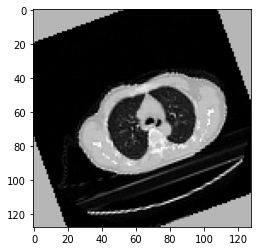

In [12]:
import matplotlib.pyplot as plt

img = x_train_aug[20]
print("Dimension of the CT scan is:", img.shape)
print(np.max(img), np.min(img))
plt.imshow(img[:,:,80], cmap="gray")

In [13]:
# Merge raw data and augmented data
x_all = np.concatenate((x_train_aug, x_train), axis=0)
x_all = np.expand_dims(x_all, axis=4)
y_all = np.concatenate((y_train_aug, y_train), axis=0)
print(x_all.shape, y_all.shape)

(84, 128, 128, 128, 1) (84, 2)


In [14]:
def get_model(img_size, num_classes):
  """
  Build a 3D convolutional neural network model

  Args:
    img_size : size of input
    num_classes : number of output classes

  Returns
    3D CNN model 
  """
  
  inputs = keras.Input(img_size)

  x = layers.Conv3D(filters=16, kernel_size=3, activation='relu')(inputs)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)  

  x = layers.Conv3D(filters=32, kernel_size=3, activation='relu')(x)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv3D(filters=64, kernel_size=3, activation='relu')(x)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv3D(filters=128, kernel_size=3, activation='relu')(x)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Flatten()(x)
  x = layers.Dense(units=256, activation='relu')(x)
  x = layers.Dropout(0.1)(x)
  
  outputs = layers.Dense(units=2, activation='softmax')(x)

  # Define the model
  model = keras.Model(inputs, outputs)
  return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model((128, 128, 128, 1), 2)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 128, 1) 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 126, 16) 448       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 63, 16)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 63, 16)    64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 61, 32)    13856     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 30, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 30, 32)   

In [15]:
# Compile model
# We use the "binary_crossentropy"
# for the binary classification problem
model.compile(loss="binary_crossentropy", 
              optimizer=keras.optimizers.Adam(1e-6), metrics=["acc"]) 

callbacks = [
    keras.callbacks.ModelCheckpoint("3d_image_classification.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=8)
]

# Train the model, doing validation at the end of each epoch.
epochs=100
model.fit(x_all,y_all,validation_data=(x_test,y_test),
          batch_size=2, epochs=epochs, 
          shuffle=True, verbose=2,
          callbacks=callbacks)

Epoch 1/100
42/42 - 10s - loss: 1.0725 - acc: 0.4524 - val_loss: 0.7387 - val_acc: 0.5000
Epoch 2/100
42/42 - 10s - loss: 0.8045 - acc: 0.4762 - val_loss: 0.7897 - val_acc: 0.5000
Epoch 3/100
42/42 - 10s - loss: 0.7272 - acc: 0.5833 - val_loss: 0.8512 - val_acc: 0.5000
Epoch 4/100
42/42 - 10s - loss: 0.5483 - acc: 0.7262 - val_loss: 0.9220 - val_acc: 0.5000
Epoch 5/100
42/42 - 10s - loss: 0.4912 - acc: 0.7738 - val_loss: 0.7993 - val_acc: 0.5000
Epoch 6/100
42/42 - 10s - loss: 0.4313 - acc: 0.7976 - val_loss: 0.7390 - val_acc: 0.5000
Epoch 7/100
42/42 - 10s - loss: 0.3265 - acc: 0.9286 - val_loss: 0.8069 - val_acc: 0.5000
Epoch 8/100
42/42 - 10s - loss: 0.2680 - acc: 0.9167 - val_loss: 0.8364 - val_acc: 0.5000
Epoch 9/100
42/42 - 10s - loss: 0.3220 - acc: 0.8810 - val_loss: 0.7540 - val_acc: 0.5833
Epoch 10/100
42/42 - 10s - loss: 0.2607 - acc: 0.9167 - val_loss: 0.6382 - val_acc: 0.6667
Epoch 11/100
42/42 - 10s - loss: 0.2534 - acc: 0.9524 - val_loss: 0.5929 - val_acc: 0.6667
Epoch 12

### Visualizing model performance

Here we plot the model accuracy and loss for the training and the validation sets. It is important to note that no random seed is specified in this notebook. Expect slight variances in your results.

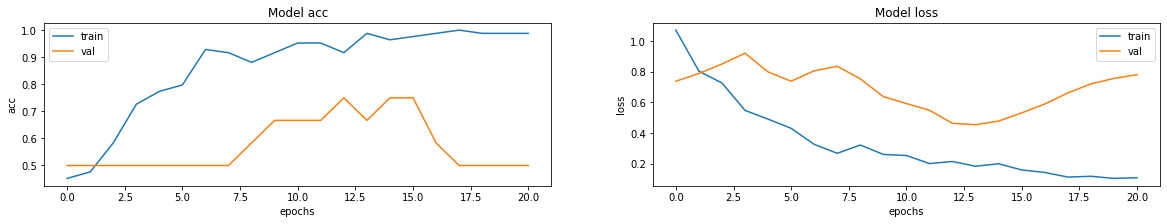

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[met])
    ax[i].plot(model.history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])


In [17]:
#Predict and evaluate results
# Inference
model.load_weights("3d_image_classification.h5")
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss: %.2f" %(score[0]))
print("Test accuracy: %.2f" %(100 * score[1]))

Test loss: 0.45
Test accuracy: 66.67


In [18]:
prediction = model.predict(np.expand_dims(x_test[0], axis=0))[0]
scores = [prediction[0], prediction[1]]

CLASS_NAMES = ["left", "right"]
for score, name in zip(scores, CLASS_NAMES):
  print("This model is %.2f percent confident that cancer in the %s side" %((100 * score), name))

This model is 51.40 percent confident that cancer in the left side
This model is 48.60 percent confident that cancer in the right side
